In [1]:
import numpy as np
from sdm.config import get_db_connection
from sdm.crud_embeddings import get_all_embeddings
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

## Get data from postgres

In [2]:
with get_db_connection(db_type="postgres") as db:
    df = get_all_embeddings(db)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112055 entries, 0 to 112054
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         112055 non-null  int64 
 1   text       112055 non-null  object
 2   doc_type   112055 non-null  object
 3   doc_id     112055 non-null  object
 4   embedding  112055 non-null  object
dtypes: int64(1), object(4)
memory usage: 4.3+ MB


In [3]:
X = df["embedding"].tolist()

In [11]:
scores = []

# elbow method like in data mining
# for n_cluster in range(2, 60, 3):
# for n_cluster in range(2, 12):
for n_cluster in range(50_000, 50_001):
    kmeans = KMeans(n_clusters=n_cluster, random_state=42).fit(X)
    label = kmeans.labels_
    db_score = davies_bouldin_score(X, label)
    sil_score = silhouette_score(X, label)
    scores.append({
        "K": n_cluster,
        "inertia": kmeans.inertia_,
        "db": db_score,
        "silh": sil_score,
        })

KeyboardInterrupt: 

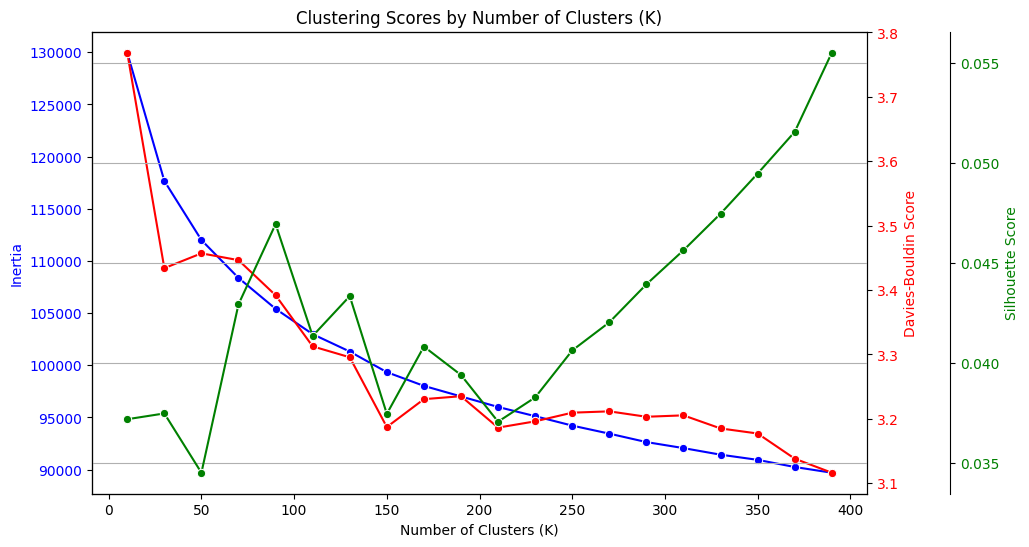

In [7]:
df_scores = pd.DataFrame(scores)
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot inertia
sns.lineplot(data=df_scores, x="K", y="inertia", ax=ax1, color="blue", marker="o")
ax1.set_ylabel("Inertia", color="blue")
ax1.set_xlabel("Number of Clusters (K)")
ax1.tick_params(axis='y', labelcolor="blue")

# Create a second y-axis for the Davies-Bouldin score
ax2 = ax1.twinx()
sns.lineplot(data=df_scores, x="K", y="db", ax=ax2, color="red", marker="o")
ax2.set_ylabel("Davies-Bouldin Score", color="red")
ax2.tick_params(axis='y', labelcolor="red")

# Create a third y-axis for the Silhouette score
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Move the third axis to avoid overlap
sns.lineplot(data=df_scores, x="K", y="silh", ax=ax3, color="green", marker="o")
ax3.set_ylabel("Silhouette Score", color="green")
ax3.tick_params(axis='y', labelcolor="green")

plt.title('Clustering Scores by Number of Clusters (K)')
plt.grid(True)
plt.show()

In [4]:
K = 500
kmeans = KMeans(n_clusters=K, random_state=42).fit(X)
labels = kmeans.labels_

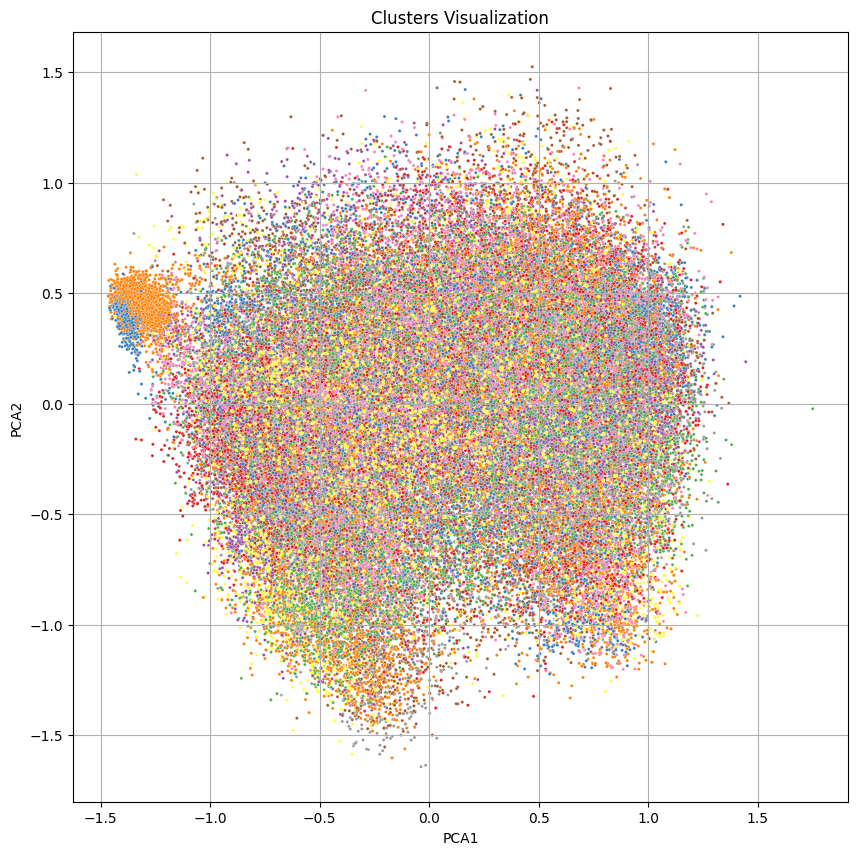

In [5]:
df["labels"] = labels
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(df["embedding"].tolist())

# Add reduced components to the dataframe for plotting
df['PCA1'] = X_reduced[:, 0]
df['PCA2'] = X_reduced[:, 1]

plt.figure(figsize=(10, 10))
sns.scatterplot(x='PCA1', y='PCA2', hue='labels', palette='Set1', data=df, s=5, legend=False)
plt.title('Clusters Visualization')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.grid(True)
plt.show()

In [6]:
tsne = TSNE(n_components=2, random_state=42)
X_reduced = tsne.fit_transform(np.array(df["embedding"].tolist())) # tsne does not like list of lists :/

df['TSNE1'] = X_reduced[:, 0]
df['TSNE2'] = X_reduced[:, 1]

## Plot Clusters

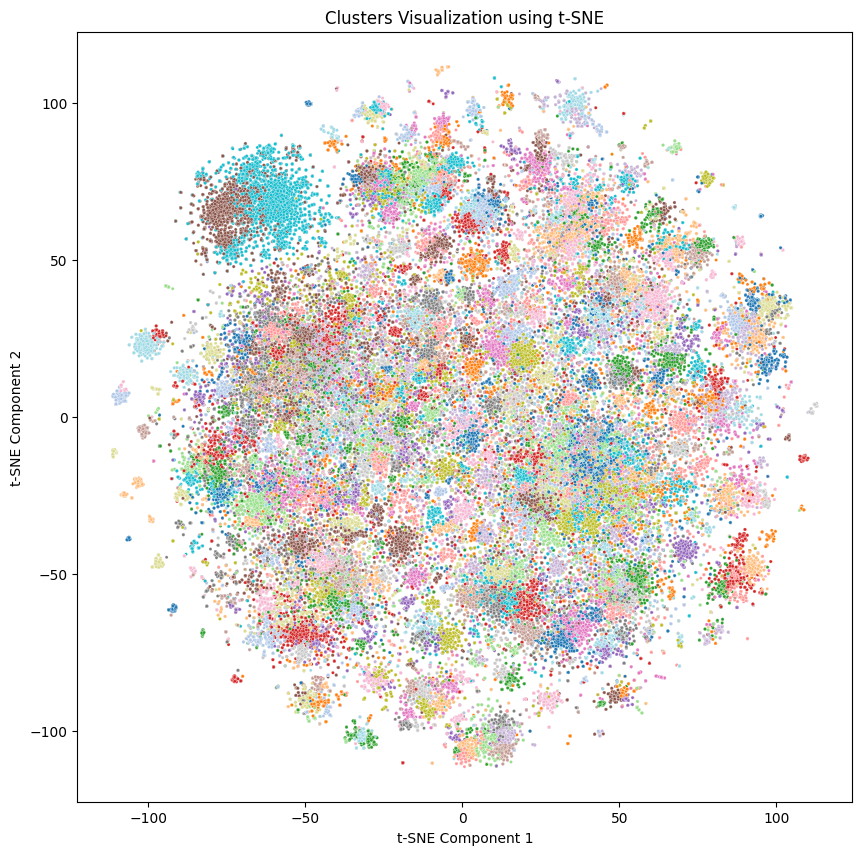

In [7]:
plt.figure(figsize=(10, 10))
ax = sns.scatterplot(x='TSNE1', y='TSNE2', hue='labels', palette='tab20', data=df, s=5, legend=False)

plt.title('Clusters Visualization using t-SNE')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

## Compare by platform/doctype

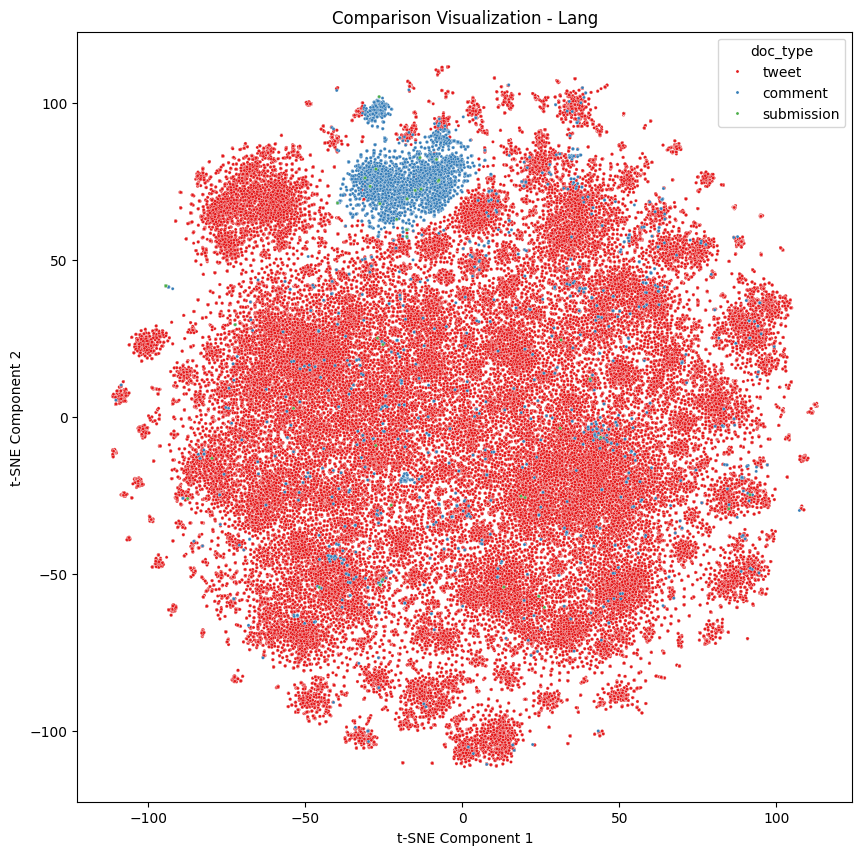

In [8]:
plt.figure(figsize=(10, 10))
ax = sns.scatterplot(x='TSNE1', y='TSNE2', hue='doc_type',
                     palette="Set1",
                     data=df, s=5, legend=True)

plt.title('Comparison Visualization - Lang')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

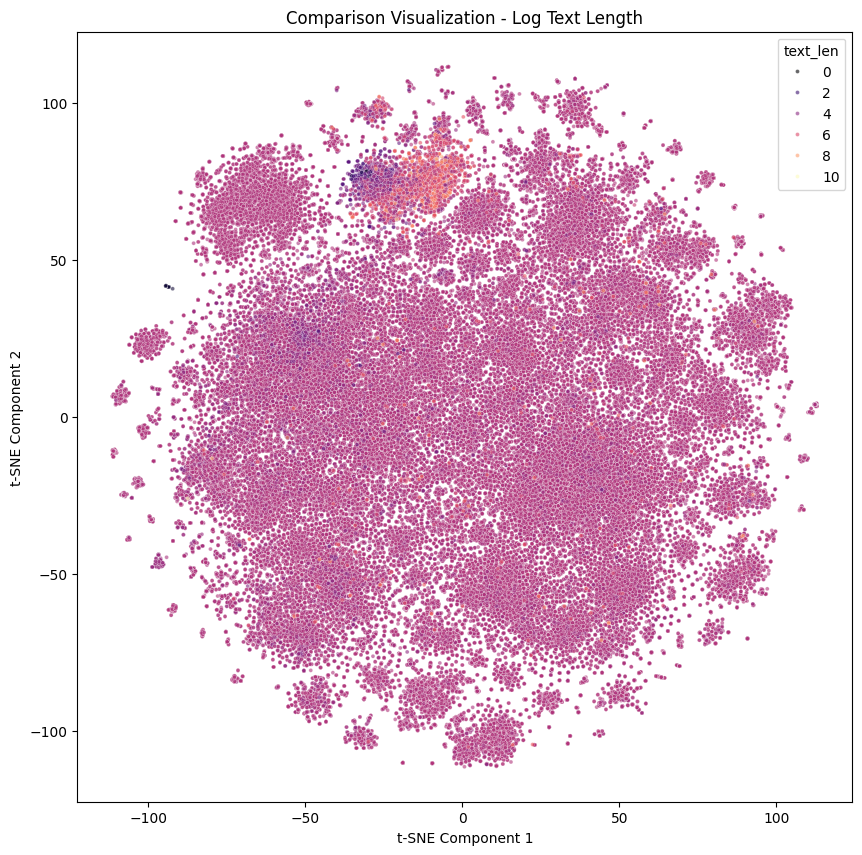

In [9]:
df["text_len"] = df["text"].apply(lambda x: np.log(len(x)))
plt.figure(figsize=(10, 10))
ax = sns.scatterplot(x="TSNE1", y="TSNE2", hue="text_len",
                     palette="magma",
                     data=df, s=8, alpha=0.6, legend=True)

plt.title("Comparison Visualization - Log Text Length")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

## Shannon entropy as measurement of mixture in clusters

Median entropy: 0.023605232515157396
Total count of labels with a mix of doc_types: 259


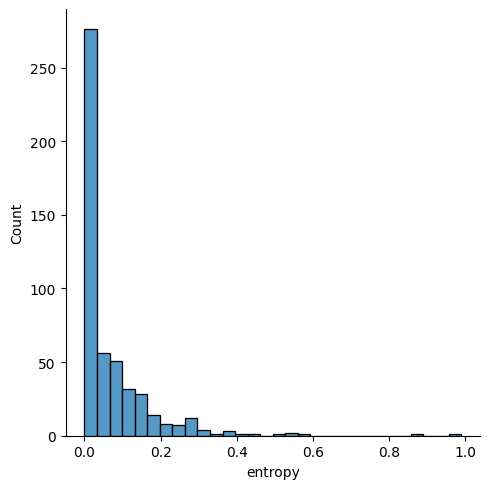

In [10]:
from scipy.stats import entropy

def shannon_entropy(cluster: pd.Series):
    _, counts = np.unique(cluster, return_counts=True)
    return entropy(counts, base=2)

df["entropy"] = df.groupby("labels")["doc_type"].transform(shannon_entropy)
sns.displot(df[['labels', 'entropy']].drop_duplicates()["entropy"], bins=30)
avg_entropy = np.median(df[['labels', 'entropy']].drop_duplicates()['entropy'])
print(f"Median entropy: {avg_entropy}")
label_doc_type_counts = df.groupby('labels')['doc_type'].nunique()
mixed_labels = label_doc_type_counts[label_doc_type_counts > 1]
print("Total count of labels with a mix of doc_types:", mixed_labels.count())

## Intruder detection

In [57]:
# TODO add to lib
def intruder_detection(df, num_samples=3):
    cluster = df['labels'].sample(n=1).values[0]
    same_cluster_samples = df[df['labels'] == cluster].sample(n=2, random_state=42)
    different_cluster_samples = df[df['labels'] != cluster].sample(n=1, random_state=42)
    intruder_group = pd.concat([same_cluster_samples, different_cluster_samples])
    for _, row in intruder_group.sample(frac=1).iterrows():
        print(f"Text from Cluster {row['labels']}, Platform: {row['doc_type']}")
        print(f"{row['text']}\n{'-'*50}")

intruder_detection(df)

Text from Cluster 20, Platform: tweet
RT @TheWorldfolio: @Oxfam Press briefing about to start #COP21 #climatechange https://t.co/19x6XwMLsq
--------------------------------------------------
Text from Cluster 219, Platform: tweet
RT @RAN: .@RAN says real test for new govt, private sector forest climate initiative is real change on the ground. https://t.co/nJ7AJDHPWl …
--------------------------------------------------
Text from Cluster 219, Platform: tweet
#COP21 @CIFOR side event, panelists say land and #forest based #mitigation must not weaken efforts to phase out #fossilfuels
--------------------------------------------------


In [58]:
df.groupby("labels")["id"].count().describe()

count     500.000000
mean      224.110000
std       210.782381
min         1.000000
25%       118.750000
50%       193.500000
75%       278.000000
max      3537.000000
Name: id, dtype: float64

## Shannon entropy as measurement of mixture in clusters

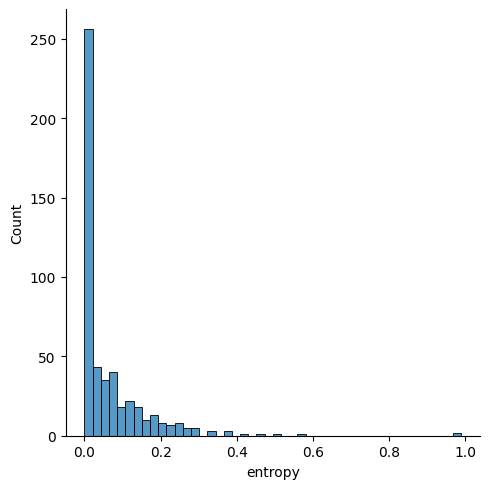

In [72]:
from scipy.stats import entropy

def shannon_entropy(cluster: pd.Series):
    _, counts = np.unique(cluster, return_counts=True)
    return entropy(counts, base=2)

df["entropy"] = df.groupby("labels")["doc_type"].transform(shannon_entropy)
sns.displot(df[['labels', 'entropy']].drop_duplicates()["entropy"])

## Fun clusters

Topic 87 with K=95, random state 42: _Polar bears_ (love this one)

In [22]:
for _, x in df[df["labels"] == 87].iterrows():
    print("--"*20)
    print(x["text"])

----------------------------------------
Polar bears are scientists more than anything else??
----------------------------------------
The coolest thing about polar bears is that they were able to exploit the sea ice at all! Imagine rolling up on an area of snow and ice as far as the eye can see. To the uninitiated, the Arctic looks like something from another planet, but polar bears, along with Arctic Peoples, managed to see the potential and learned how to survive.
----------------------------------------
Polar bears have evolved over about 350,000 years to become highly specialized predators of ice seals. In most of the Arctic, they rarely came to land and prefer to remain out on the floating sea ice- which is why they are considered a marine mammal in the US and elsewhere. While polar bears stranded onshore will sometimes eat terrestrial foods- they are obligate carnivores and the latest research into their physiology and energetic requirements conclude that terrestrial foods are i